Here are the functions used during data preprocessing, training, and testing:

In [1]:
##Use the tokenizer to encode the text
def encode(data_component):
    encoded_data = tokenizer(data_component, return_tensors='pt', padding="max_length", truncation=True, max_length=512)  #Force max length here to make sure tensors fit
    return encoded_data["input_ids"], encoded_data["attention_mask"]


##outputs the accuracy of the model
def accuracy(predictions, labels):
    preds = torch.argmax(torch.softmax(predictions, dim=1), dim=1)  # Get class with highest probability
    return (preds == labels).float().mean().item()



##Training loop
def train(bert_classifier, device, trainloader, valloader, criterion, optimizer, epochs, PATH):
    running_acc = []  # Store accuracy values for logging
    running_train_loss = []  # Store training loss for visualization
    running_val_loss = []  # Store validation loss

    for epoch in range(epochs):
        epoch_loss = 0.0  
        training_acc = 0.0  
        training_loss = 0.0
        
        bert_classifier.train()  # Set model to training mode

        # Training loop
        for i, batch in enumerate(trainloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()  
            
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            logits = bert_classifier(input_ids=input_ids, attention_mask=attention_mask)
            
            # Compute loss
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()  # Update weights
            
            # Accumulate loss and accuracy
            epoch_loss += loss.item()
            training_loss += loss.item()
            training_acc += accuracy(logits, labels)  # Assume `accuracy` function is defined

            # Print loss and accuracy every 5 batches
            if (i + 1) % 5 == 0: 
                avg_acc = training_acc / 5
                avg_loss = training_loss / 5

                print(f'Epoch {epoch}, Batch {i+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')
                
                running_acc.append(avg_acc)

                # Reset batch accumulators
                training_loss = 0.0
                training_acc = 0.0

        # Store training loss for visualization
        avg_train_loss = epoch_loss / len(trainloader)
        running_train_loss.append(avg_train_loss)

        # Save checkpoint every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': bert_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, PATH)
        
        # Validation loop
        running_vloss = 0.0
        bert_classifier.eval()  # Set model to evaluation mode

        with torch.no_grad():
            val_acc = 0.0
            val_steps = 0
            
            for vbatch in valloader:
                vinputs = vbatch[0].to(device)
                vattention_mask = vbatch[1].to(device)
                vlabels = vbatch[2].to(device).long()

                vlogits = bert_classifier(input_ids=vinputs, attention_mask=vattention_mask)
                vloss = criterion(vlogits, vlabels)
                
                running_vloss += vloss.item()
                val_acc += accuracy(vlogits, vlabels)  
                val_steps += 1

            avg_vloss = running_vloss / val_steps
            avg_vacc = val_acc / val_steps
            running_val_loss.append(avg_vloss)

            print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.4f}, '
                  f'Validation Loss: {avg_vloss:.4f}, Validation Accuracy: {avg_vacc:.4f}')

    # **Create DataFrames for Plotting**
    df_loss = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Training Loss': running_train_loss,
        'Validation Loss': running_val_loss
    })

    df_acc = pd.DataFrame({'Batch': range(len(running_acc)), 'Accuracy': running_acc})

    df_loss.plot(x='Epoch', y=['Training Loss', 'Validation Loss'], kind='line', marker='o', title='Training vs Validation Loss', grid=True)
    df_acc.plot(x='Batch', y='Accuracy', kind='line', title='Training Accuracy Over Batches', grid=True)


#Testing Loop        
def test(bert_classifier, device, testloader, criterion, epochs):
    bert_classifier.eval()  # Set model to evaluation mode

    running_test_loss = []  # Store test loss per epoch
    running_test_acc = []  # Store test accuracy per batch

    with torch.no_grad():
        for epoch in range(epochs):
            epoch_loss = 0.0  
            testing_acc = 0.0  
            testing_loss = 0.0  
            batch_count = 0  

            for i, batch in enumerate(testloader):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device).long()

                # Forward pass
                logits = bert_classifier(input_ids=input_ids, attention_mask=attention_mask)

                # Compute loss
                loss = criterion(logits, labels)

                # Accumulate loss and accuracy
                epoch_loss += loss.item()
                testing_loss += loss.item()
                testing_acc += accuracy(logits, labels)
                batch_count += 1

                # Print loss and accuracy every 200 batches
                if (i + 1) % 200 == 0:
                    avg_acc = testing_acc / 200
                    avg_loss = testing_loss / 200
                    print(f'Epoch {epoch}, Batch {i+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')
                    
                    running_test_acc.append(avg_acc)

                    # Reset batch accumulators
                    testing_loss = 0.0
                    testing_acc = 0.0

            # Store test loss per epoch
            avg_test_loss = epoch_loss / batch_count
            running_test_loss.append(avg_test_loss)

            print(f'Epoch {epoch}, Test Loss: {avg_test_loss:.4f}')

    # **Create DataFrames for Plotting**
    df_loss = pd.DataFrame({'Epoch': range(1, epochs + 1), 'Test Loss': running_test_loss})
    df_acc = pd.DataFrame({'Batch': range(len(running_test_acc)), 'Test Accuracy': running_test_acc})

    # **Plot the test results**
    df_loss.plot(x='Epoch', y='Test Loss', kind='line', marker='o', title='Test Loss Over Epochs', grid=True)
    df_acc.plot(x='Batch', y='Test Accuracy', kind='line', title='Test Accuracy Over Batches', grid=True)

Import all the necessary libraries:

In [2]:
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split 
from torch.utils.data.dataloader import default_collate
from transformers.models.bert.modeling_bert import BertIntermediate, BertOutput, BertEncoder, BertSelfAttention, BertSelfOutput, BertModel, BertConfig

Import the question sets that will be used to train the model.  The first dataset used was the RACE dataseet, which consists of multiple choice questions separated between M (middle school) and H (high school).  The second dataset is QxGrade_dataset which is a set of 75k questions scraped from pdf textbooks.  These textbooks were chosen based on alignment with Common Core State Standards to identify a framework that we can use when training the model with additional data. 

In [3]:
df = pd.read_csv('QxGrade_Dataset.csv')

Because I already ran through the whole process, I now know the model is training to specific levels too higly.  Now, I'm going to normalize the dataset to fix this.  To start we are going to see how many questions there are for each grade.

In [4]:
grade_counts = df['Grade'].value_counts().sort_index()
print("Grade Distribution:\n", grade_counts)

Grade Distribution:
 Grade
3      418
4     1191
5     1658
6      549
7     1153
8     1805
9     8668
10    2704
11    7288
12    1125
Name: count, dtype: int64


Now I'm going to find the median size of the question sets

In [5]:
median_size = int(grade_counts.median())
print(median_size)

1424


This number is still much too high.  I am going to use the minimum value (418) and select 418 questions randomly from the other grades.

In [ ]:
target_size = 418
balanced_data = []

for grade, group in df.groupby("Grade"):
    if len(group) >= target_size:
        sampled_group = group.sample(n=target_size, random_state=42)
    else:
        sampled_group = group
    balanced_data.append(sampled_group)

df_balanced = pd.concat(balanced_data).reset_index(drop=True)


In [9]:
print(df_balanced["Grade"].value_counts())

Grade
3     418
4     418
5     418
6     418
7     418
8     418
9     418
10    418
11    418
12    418
Name: count, dtype: int64


In [10]:
df.columns

Index(['Unnamed: 0', 'question', 'Grade'], dtype='object')

In [11]:
df

,Unnamed: 0,question,Grade
0,0,How could Doug reach it?,10
1,1,co 4 He asked me to do him a favor If he fail...,10
2,2,Would Doug drop through the same space?,10
3,3,Would I follow?,10
4,4,When you fall 600 feet do you die before you ...,10
...,...,...,...
26554,2702,How many elements are in the compound Mg(OH)2?...,8
26555,2703,Which of these resources will most likely be d...,8
26556,2704,"When people exercise, they often feel thirsty ...",8
26557,2705,"According to the periodic table, all of the fo...",8


The two most important columns we will be using and labeling are Grade and Question.  Using the .values and .tolist function here we are adding all of the grade options (3-12) to the grades function.  We are doing the same with all of the question values.

In [12]:
questions = df.question.values.tolist()
grades = df.Grade.astype(str).tolist()

Tokenize the data using the encode function

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [14]:
q_tensors, attention_mask_q = encode(questions)

In [15]:
g_tensors, attention_mask_g = encode(grades)

Now set the grade values to 0

In [16]:
glabels = torch.zeros(len(g_tensors), dtype=torch.float32)

Set the question values to 1

In [17]:
qlabels = torch.ones(len(q_tensors), dtype=torch.float32)

Concatenate the two

In [18]:
training_data = torch.cat([g_tensors, q_tensors], dim=1)

Change BERT configuration to implement Dual Multihead Attention Mechanism.  This is also where we are implementing our customized neural network. 

In [19]:
##This implements a copy of the original attention mechnism to run simultaneously, then at the end, the outputs are joined together
class DualBertAttention(nn.Module):
    
    
    def __init__(self, config):
        super().__init__()
        
        self.attention1 = BertSelfAttention(config)
        self.attention2 = BertSelfAttention(config)
        
        self.output1 = BertSelfOutput(config)
        self.output2 = BertSelfOutput(config)
        
        
    def forward(self, hidden_states, attention_mask=None, head_mask=None):
        attn_output1 = self.attention1(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output1 = self.output1(attn_output1, hidden_states)

        attn_output2 = self.attention2(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output2 = self.output2(attn_output2, hidden_states)

        dual_attention_output = F.relu(attn_output1 + attn_output2)
        return dual_attention_output
    
##Implements the dual attention in the Neural Network
class DualBertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = DualBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)


##Moves the data through the Neural Network
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        attention_output = self.attention(hidden_states, attention_mask, head_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return (layer_output,)


##Implments the outcome from the DualBertLayer to encode the data from the DualBertLayer Class
class DualBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.layer = nn.ModuleList([DualBertLayer(config) for _ in range(config.num_hidden_layers)])


##Implements the model with the DualBertEncoder
class DualBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = DualBertEncoder(config)


##Initialize a classifier between the 10 different options (3rd grade to 12th grade).

class BertClassifier(nn.Module):
    def __init__(self, bert, hidden_dim=768, num_classes=10): 
        super(BertClassifier, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # CLS token representation
        return self.fc(pooled_output)

Using the network we create, instantiate our version of bert

In [20]:
config = BertConfig()  
bert = DualBertModel(config) 


Set up the training hyperparameters

In [21]:
epochs = 2000  ##How many times we go through the loop
criterion = nn.CrossEntropyLoss()  ##This compares the predicted answer with the correct answer
optimizer = optim.Adam(bert.parameters(), lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-5)  ##The Optim.Adam optimizer calculates gradient descent
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  ##Set the device to GPU so we can train the model on the GPU

sequence_length = 156   ## Maximum length of tokens to be used at a time
batch_size = 8  ##The number of training examples in one forward/backward pass
input_dim = 500  ##The total number of dimension we will allow the model to use for calculation
d_model = 512  ##Number of expected features, set to default recommended by pytorch
running_acc = []  ##This is to agregate the training data
save_every = 1 ##Saves the model after each epoch
PATH = 'bert_checkpoint.pt'

Wrap the data in a Dataloader:

In [22]:

q_dataset = TensorDataset(q_tensors, attention_mask_q, qlabels.long())  # Convert qlabels to long
g_dataset = TensorDataset(g_tensors, attention_mask_g, glabels.long())  # Convert glabels to l

dataset = torch.utils.data.ConcatDataset([q_dataset, g_dataset])


#split datasets with random split
train_size = int(0.7 * len(dataset))  # 70% training
val_size = int(0.15 * len(dataset))   # 15% validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% test

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])


trainloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)

valloader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=custom_collate)  

testloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate )

NameError: name 'custom_collate' is not defined

Move the model to the GPU

In [ ]:
bert.to(device)

Move an instance of the bert classifier to the device as well

In [ ]:
bert_classifier = BertClassifier(bert).to(device)


Use Bert to classify the data -- Running this training function requires approximately 37-38 gb of VRam

In [ ]:
train(bert_classifier, device, trainloader, valloader, criterion, optimizer, epochs, PATH)


Save the model once trained 

In [ ]:
torch.save(bert_classifier.state_dict(), 'Bert_Classifier.pt')

In [ ]:
model = BertClassifier(bert)

#Load Saved State Dictionary
state_dict = torch.load("Bert_Classifier.pt", map_location=torch.device("cpu"))
model.load_state_dict(state_dict)
model.to(device)

test(model, device, testloader, criterion, epochs)

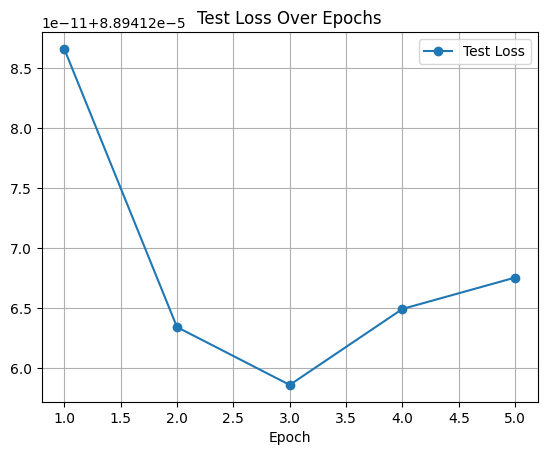

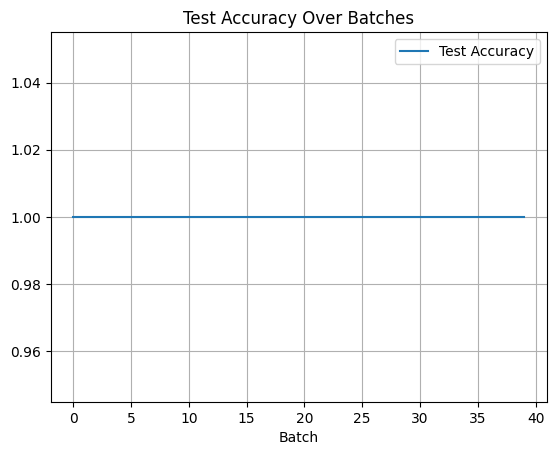